Title: Term Project 1  
Author: Adam McMahan  
Date: 28 August 2018  
Modified By: Adam McMahan  
Description: This program demonstrates the use of Python types, values, and  
and variables in an application.  

### Libraries

In [43]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Survival analysis
from lifelines import KaplanMeierFitter

# SMOTE
from imblearn.over_sampling import SMOTE

# Hierarchial Regression
import statsmodels.api as sm

# Miscellaneous
import warnings
warnings.filterwarnings('ignore')

### Data Information

In [7]:
# Name filepath
file_path = r"C:\Users\Adam\OneDrive\Desktop\DSC 680 - Applied Data Science\HRData.csv"

# Load in data
df = pd.read_csv(file_path)

# Test
print(df.head())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

### Summary Statistics

In [11]:
# Descriptive statistics
print("\nDescriptive Statistics (Numeric):\n", df.describe())

# Correlations
def corr_with_pvalues(df):
    df_numeric = df.select_dtypes(include=[np.number])
    cols = df_numeric.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    pval_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for col1 in cols:
        for col2 in cols:
            corr, pval = pearsonr(df_numeric[col1], df_numeric[col2])
            corr_matrix.loc[col1, col2] = corr
            pval_matrix.loc[col1, col2] = pval

    return corr_matrix, pval_matrix

corrs, pvals = corr_with_pvalues(df)

print("Correlation Coefficients:")
print(corrs)

print("\nP-values:")
print(pvals)


Descriptive Statistics (Numeric):
                Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932 

##### Notes
Significant correlations
Education: Job level(.1, <.000), YearsatCompany (.07, <.008), YearsInCurrentRole (.06, <.021), ...lastpromo(.05, <.038), currmanager(.07, <.008)

### Modeling: Random Forest

In [15]:
# Encode variable preparing for modeling and survival analysis
df['Attrition_Flag'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Relevant variables to analysis
df_encoded = pd.get_dummies(df, columns=['EducationField', 'JobRole', 'OverTime'], drop_first=True)

features = [
    'Education', 'TotalWorkingYears', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'Attrition_Flag'
] + [col for col in df_encoded.columns if col.startswith(('EducationField_', 'JobRole_', 'OverTime_'))]

df_model = df_encoded[features]

# Define features and target
X = df_model.drop('Attrition_Flag', axis=1)
y = df_model['Attrition_Flag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8503401360544217
Confusion Matrix:
 [[363  17]
 [ 49  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       380
           1       0.41      0.20      0.27        61

    accuracy                           0.85       441
   macro avg       0.65      0.58      0.59       441
weighted avg       0.82      0.85      0.83       441



##### Model notes:  
Class 1 seems to be very low. Likely due to imabalance of yes v no on attrition.  
Trying SMOTE to address the imbalance (Song, 2025)

In [18]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train again
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[324  45]
 [ 38 333]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       369
           1       0.88      0.90      0.89       371

    accuracy                           0.89       740
   macro avg       0.89      0.89      0.89       740
weighted avg       0.89      0.89      0.89       740



##### Model notes: 
The application of SMOTE in this analysis significantly improved the predictive performacne of the Random Forest classifier in the identifying employee attrition. Initally, the model exhibited strong accuracy but poor recall and precision for the minority class (employees who left), reflecting a common issue in imbalanced datasets where the majority class dominate learning (Song, 2025). By synthetically generating new instances of the minority class through interpolation between existing samples, SMOTE enhanced the model's ability to generalize and recognize attrition patterns. Post-SMOTE, the classifier achieved balanced precision, recall, and F1-scores across both classes, indicating a more equitable and reliable prediction framework. This outcome udnerscores the improtance of addressing class imbalance in workforce analytics, where minority outcomescarry critical strategic implications, though are less frequent. 

### Modeling: Kaplan-Meier Survival Analysis

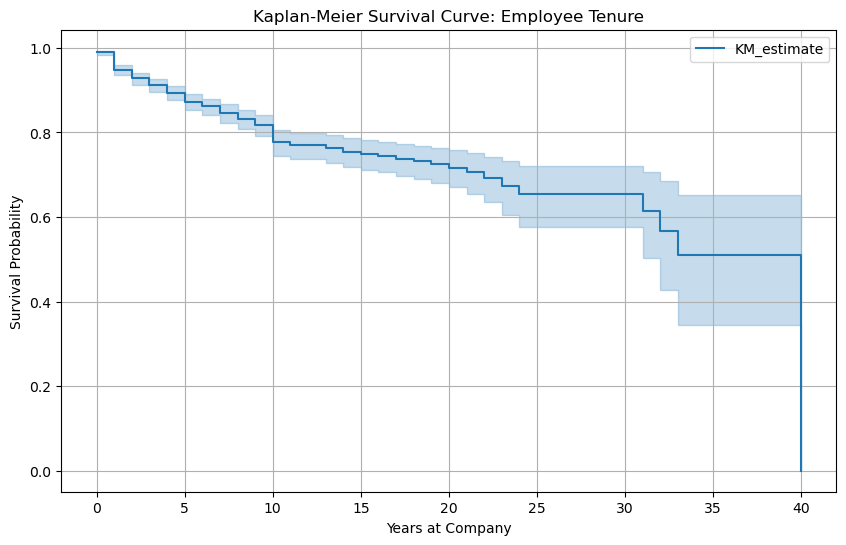

In [22]:
# Initialize the model
kmf = KaplanMeierFitter()

# Fit the model using tenure and attrition
kmf.fit(durations=df['YearsAtCompany'], event_observed=df['Attrition_Flag'])

# Plot the survival function
plt.figure(figsize=(10,6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve: Employee Tenure')
plt.xlabel('Years at Company')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

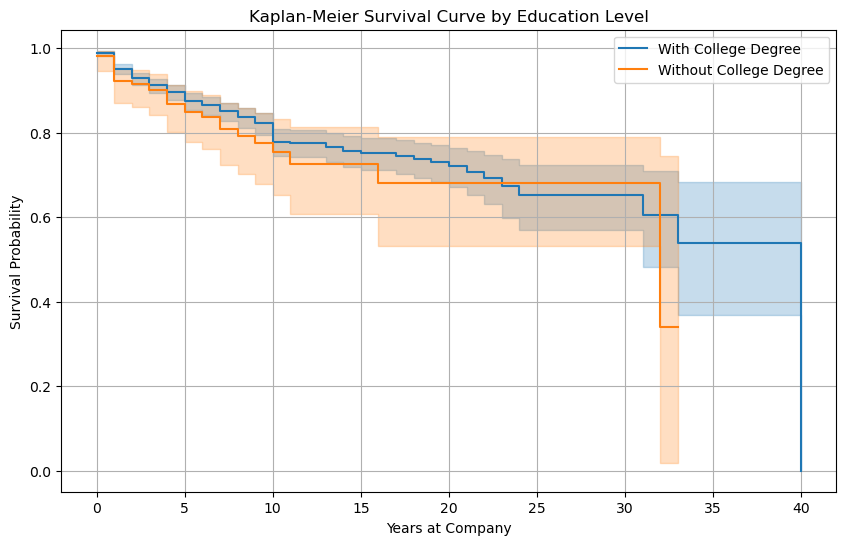

In [24]:
# Initialize the model
kmf = KaplanMeierFitter()

# Split the data
degree_yes = df[df['Education'] >= 2]
degree_no = df[df['Education'] < 2]

# Plot setup
plt.figure(figsize=(10,6))

# With college degree
kmf.fit(durations=degree_yes['YearsAtCompany'], event_observed=degree_yes['Attrition_Flag'], label='With College Degree')
kmf.plot_survival_function()

# Without college degree
kmf.fit(durations=degree_no['YearsAtCompany'], event_observed=degree_no['Attrition_Flag'], label='Without College Degree')
kmf.plot_survival_function()

# Final touches
plt.title('Kaplan-Meier Survival Curve by Education Level')
plt.xlabel('Years at Company')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()


##### Model notes:
There appears to be a subtle, yet meaningful difference in the chocie to stay with a company depending on college degrees. Those without them appear to leave sooner than those without. Though this does not immedately address the why, the first 10 years at a company appear to be critical for both. 

### Modeling: Logistic Regression

In [28]:
features = ['Education', 'JobLevel', 'YearsAtCompany',
            'YearsInCurrentRole', 'YearsSinceLastPromotion',
            'YearsWithCurrManager']
X = df[features]
y = df['Attrition_Flag']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
print(coeffs.sort_values(by='Coefficient', ascending=False))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       380
           1       0.00      0.00      0.00        61

    accuracy                           0.86       441
   macro avg       0.43      0.50      0.46       441
weighted avg       0.74      0.86      0.80       441

                   Feature  Coefficient
4  YearsSinceLastPromotion     0.129761
2           YearsAtCompany     0.022552
0                Education     0.012208
5     YearsWithCurrManager    -0.069804
3       YearsInCurrentRole    -0.171838
1                 JobLevel    -0.449584


##### Model notes
Imbalanced challenges are likely the cause for the model to fail to identify who leaves. 

### Modeling: Decision Trees

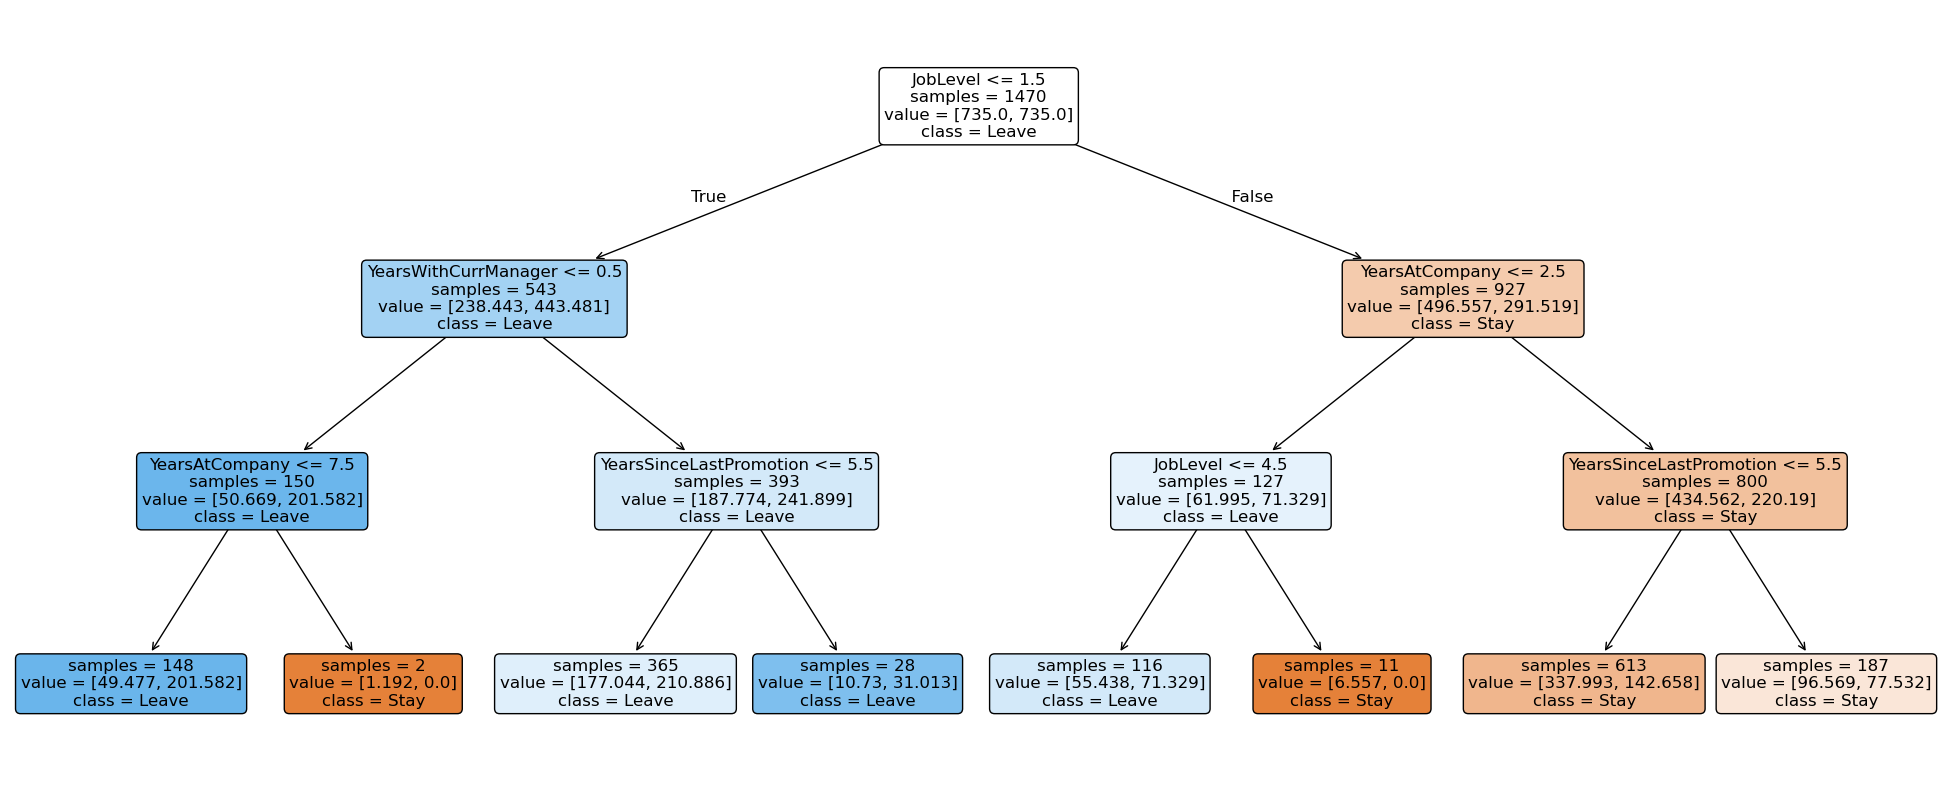

In [32]:
# Fit the model
model = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)
model.fit(X, y)

# Plot with simplified labels
plt.figure(figsize=(25,10))
plot_tree(model,
          feature_names=features,
          class_names=['Stay', 'Leave'],
          filled=True,
          impurity=False,     # Removes gini
          proportion=False,   # Removes class proportions
          rounded=True,
          fontsize=12)
plt.show()

##### Model notes
Interesting that education is not used in the tree. It likely may not be a strong predictor, and may indiciate that its predictve power is mediated through other variables. 

### Modeling: Monte-Carlo

In [36]:
np.random.seed(42)
n = 10000

# Randomly assign education levels
education_levels = np.random.choice([1,2,3,4,5], size=n, p=[0.1, 0.2, 0.4, 0.2, 0.1])

# Assign attrition probabilities
prob_map = {1: 0.30, 2: 0.20, 3: 0.15, 4: 0.10, 5: 0.05}
attrition_probs = np.array([prob_map[edu] for edu in education_levels])

# Simulate attrition
attrition = np.random.binomial(1, attrition_probs)

# Create DataFrame
df_sim = pd.DataFrame({'Education': education_levels, 'Attrition': attrition})

results = df_sim.groupby('Education')['Attrition'].mean().reset_index()
results.columns = ['Education Level', 'Simulated Attrition Rate']
print(results)

   Education Level  Simulated Attrition Rate
0                1                  0.310378
1                2                  0.203759
2                3                  0.152463
3                4                  0.093977
4                5                  0.047867


##### Model notes
Greater risk of attrition with no college degree, decreasing as terminal degree level increases. 

### Modeling: Hierarchial Regression

Optimization terminated successfully.
         Current function value: 0.425065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411299
         Iterations 7
Model 1: Demographics
                           Logit Regression Results                           
Dep. Variable:         Attrition_Flag   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1467
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Oct 2025   Pseudo R-squ.:                 0.03765
Time:                        18:01:28   Log-Likelihood:                -624.85
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 2.418e-11
                 coef    std err        

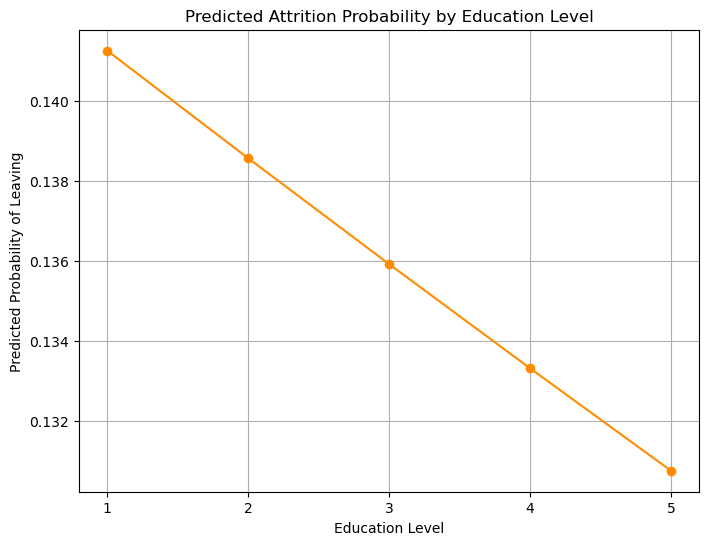

In [41]:
required_cols = ['Attrition_Flag', 'Education', 'JobLevel',
                 'YearsAtCompany', 'YearsInCurrentRole',
                 'YearsWithCurrManager', 'YearsSinceLastPromotion']
df = df.dropna(subset=required_cols)

# Define blocks
# Block 1: Demographics
X1 = sm.add_constant(df[['Education', 'JobLevel']])

# Block 2: Add Tenure & Stability
X2 = sm.add_constant(df[['Education', 'JobLevel',
                         'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']])

# Block 3: Add Career Progression
X3 = sm.add_constant(df[['Education', 'JobLevel',
                         'YearsAtCompany', 'YearsInCurrentRole',
                         'YearsWithCurrManager', 'YearsSinceLastPromotion']])

# Define dependent variable
y = df['Attrition_Flag']

# Fit models
model1 = sm.Logit(y, X1).fit()
model2 = sm.Logit(y, X2).fit()
model3 = sm.Logit(y, X3).fit()

# Print summaries
print("Model 1: Demographics")
print(model1.summary())
print("\nModel 2: + Tenure & Stability")
print(model2.summary())
print("\nModel 3: + Career Progression")
print(model3.summary())

# Plot predicted attrition probability by education level
education_range = np.arange(1, 6)

# Use average values for other predictors
avg_vals = {
    'JobLevel': df['JobLevel'].mean(),
    'YearsAtCompany': df['YearsAtCompany'].mean(),
    'YearsInCurrentRole': df['YearsInCurrentRole'].mean(),
    'YearsWithCurrManager': df['YearsWithCurrManager'].mean(),
    'YearsSinceLastPromotion': df['YearsSinceLastPromotion'].mean()
}

# Build prediction DataFrame
predict_df = pd.DataFrame({
    'Education': education_range,
    'JobLevel': avg_vals['JobLevel'],
    'YearsAtCompany': avg_vals['YearsAtCompany'],
    'YearsInCurrentRole': avg_vals['YearsInCurrentRole'],
    'YearsWithCurrManager': avg_vals['YearsWithCurrManager'],
    'YearsSinceLastPromotion': avg_vals['YearsSinceLastPromotion']
})

# Add constant manually
predict_df.insert(0, 'const', 1.0)

# Predict using model3
pred_probs = model3.predict(predict_df)

# Plot
plt.figure(figsize=(8,6))
plt.plot(education_range, pred_probs, marker='o', linestyle='-', color='darkorange')
plt.title('Predicted Attrition Probability by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Predicted Probability of Leaving')
plt.xticks(education_range)
plt.grid(True)
plt.show()